# Ethereum Blockchain Analysis with Ethereum-ETL and Bacalhau

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/data-engineering/blockchain-etl/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=data-engineering/blockchain-etl/index.ipynb)

# Introduction

Mature blockchains are difficult to analyze because of their size. Ethereum-ETL is a tool that makes it easy to extract information from an Ethereum node, but it's not easy to get working in a batch manner. It takes approximately 1 week for an Ethereum node to download the entire chain (event more in my experience) and importing and exporting data from the Ethereum node is slow.

For this example, we ran an Ethereum node for a week and allowed it to synchronise. We then ran ethereum-etl to extract the information and pinned it on Filecoin. This means that we can both now access the data without having to run another ethereum node.

But there's still a lot of data and these types of analyses typically need repeating or refining. So it makes absolute sense to use a decentralised network like Bacalhau to process the data in a scalable way.

### Prerequisites

* Python 3 
* The Bacalhau client - [Installation instructions](https://docs.bacalhau.org/getting-started/installation)

In [1]:
!command -v bacalhau >/dev/null 2>&1 || (export BACALHAU_INSTALL_DIR=.; curl -sL https://get.bacalhau.org/install.sh | bash)
path=!echo $PATH
%env PATH=./:{path[-1]}

/Users/phil/.zshenv:.:1: no such file or directory: /Users/phil/.cargo/env
env: PATH=./:/Users/phil/.pyenv/versions/3.9.7/bin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.gvm/bin:/opt/homebrew/opt/findutils/libexec/gnubin:/opt/homebrew/opt/coreutils/libexec/gnubin:/opt/homebrew/Caskroom/google-cloud-sdk/latest/google-cloud-sdk/bin:/Users/phil/.pyenv/shims:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/usr/local/MacGPG2/bin:/Users/phil/source/bacalhau-project/examples/workload-onboarding/rust-wasm/./bin:/Users/phil/.nexustools


## 1. Analysing Ethereum Data Locally

First let's download one of the IPFS files and inspect it locally. You can see the full list of IPFS CIDs in the appendix.

In [2]:
%%bash
wget -q -O file.tar.gz https://w3s.link/ipfs/bafybeifgqjvmzbtz427bne7af5tbndmvniabaex77us6l637gqtb2iwlwq
tar -xvf file.tar.gz

x output_850000/
x output_850000/token_transfers/
x output_850000/token_transfers/start_block=00850000/
x output_850000/token_transfers/start_block=00850000/end_block=00899999/
x output_850000/token_transfers/start_block=00850000/end_block=00899999/token_transfers_00850000_00899999.csv
x output_850000/contracts/
x output_850000/contracts/start_block=00850000/
x output_850000/contracts/start_block=00850000/end_block=00899999/
x output_850000/contracts/start_block=00850000/end_block=00899999/contracts_00850000_00899999.csv
x output_850000/transactions/
x output_850000/transactions/start_block=00850000/
x output_850000/transactions/start_block=00850000/end_block=00899999/
x output_850000/transactions/start_block=00850000/end_block=00899999/transactions_00850000_00899999.csv
x output_850000/receipts/
x output_850000/receipts/start_block=00850000/
x output_850000/receipts/start_block=00850000/end_block=00899999/
x output_850000/receipts/start_block=00850000/end_block=00899999/receipts_00850

In [3]:
%%bash
pip install pandas

In [4]:
# Use pandas to read in transation data and clean up the columns
import pandas as pd
import glob

file = glob.glob('output_*/transactions/start_block=*/end_block=*/transactions*.csv')[0]
print("Loading file %s" % file)
df = pd.read_csv(file)
df['value'] = df['value'].astype('float')
df['from_address'] = df['from_address'].astype('string')
df['to_address'] = df['to_address'].astype('string')
df['hash'] = df['hash'].astype('string')
df['block_hash'] = df['block_hash'].astype('string')
df['block_datetime'] = pd.to_datetime(df['block_timestamp'], unit='s')
df.info()

Loading file output_850000/transactions/start_block=00850000/end_block=00899999/transactions_00850000_00899999.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115517 entries, 0 to 115516
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   hash                      115517 non-null  string        
 1   nonce                     115517 non-null  int64         
 2   block_hash                115517 non-null  string        
 3   block_number              115517 non-null  int64         
 4   transaction_index         115517 non-null  int64         
 5   from_address              115517 non-null  string        
 6   to_address                114901 non-null  string        
 7   value                     115517 non-null  float64       
 8   gas                       115517 non-null  int64         
 9   gas_price                 115517 non-null  int64         
 10  input        

The following code inspects the daily trading volume of Ethereum for a single chunk (100,000 blocks) of data.

This is all good, but we can do better. We can use the Bacalhau client to download the data from IPFS and then run the analysis on the data in the cloud. This means that we can analyse the entire Ethereum blockchain without having to download it locally.

<AxesSubplot:xlabel='block_datetime'>

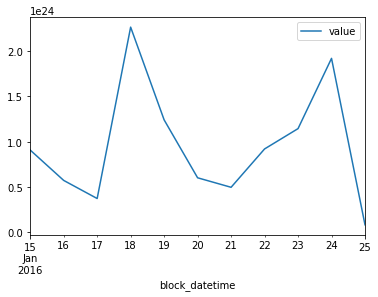

In [5]:
# Total volume per day
df[['block_datetime', 'value']].groupby(pd.Grouper(key='block_datetime', freq='1D')).sum().plot()





## 2. Analysing Ethereum Data With Bacalhau

To run jobs on the Bacalhau network you need to package your code. In this example I will package the code as a Docker image.

But before we do that, we need to develop the code that will perform the analysis. The code below is a simple script to parse the incoming data and produce a CSV file with the daily trading volume of Ethereum.

In [6]:
%%writefile main.py
import glob, os, sys, shutil, tempfile
import pandas as pd

def main(input_dir, output_dir):
    search_path = os.path.join(input_dir, "output*", "transactions", "start_block*", "end_block*", "transactions_*.csv")
    csv_files = glob.glob(search_path)
    if len(csv_files) == 0:
        print("No CSV files found in %s" % search_path)
        sys.exit(1)
    for transactions_file in csv_files:
        print("Loading %s" % transactions_file)
        df = pd.read_csv(transactions_file)
        df['value'] = df['value'].astype('float')
        df['block_datetime'] = pd.to_datetime(df['block_timestamp'], unit='s')
        
        print("Processing %d blocks" % (df.shape[0]))
        results = df[['block_datetime', 'value']].groupby(pd.Grouper(key='block_datetime', freq='1D')).sum()
        print("Finished processing %d days worth of records" % (results.shape[0]))

        save_path = os.path.join(output_dir, os.path.basename(transactions_file))
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        print("Saving to %s" % (save_path))
        results.to_csv(save_path)

def extractData(input_dir, output_dir):
    search_path = os.path.join(input_dir, "*.tar.gz")
    gz_files = glob.glob(search_path)
    if len(gz_files) == 0:
        print("No tar.gz files found in %s" % search_path)
        sys.exit(1)
    for f in gz_files:
        shutil.unpack_archive(filename=f, extract_dir=output_dir)

if __name__ == "__main__":
    if len(sys.argv) != 3:
        print('Must pass arguments. Format: [command] input_dir output_dir')
        sys.exit()
    with tempfile.TemporaryDirectory() as tmp_dir:
        extractData(sys.argv[1], tmp_dir)
        main(tmp_dir, sys.argv[2])

Overwriting main.py


Next, let's make sure the file works as expected...

In [7]:
%%bash
python main.py . outputs/

Loading /var/folders/kr/pl4p96k11b55hp5_p9l_t8kr0000gn/T/tmp63wukfr3/output_850000/transactions/start_block=00850000/end_block=00899999/transactions_00850000_00899999.csv
Processing 115517 blocks
Finished processing 11 days worth of records
Saving to outputs/transactions_00850000_00899999.csv


And finally, package the code inside a Docker image to make the process reproducible. Here I'm passing the Bacalhau default `/inputs` and `/outputs` directories. The `/inputs` directory is where the data will be read from and the `/outputs` directory is where the results will be saved to.

In [8]:
%%writefile Dockerfile
FROM python:3.11-slim-bullseye
WORKDIR /src
RUN pip install pandas==1.5.1
ADD main.py .
CMD ["python", "main.py", "/inputs", "/outputs"]

Overwriting Dockerfile


We've already pushed the container, but for posterity, the following command pushes this container to GHCR.

```bash
docker buildx build --platform linux/amd64 --push -t ghcr.io/bacalhau-project/examples/blockchain-etl:0.0.1 .
```


### Analysing Ethereum Data On Bacalhau

[Bacalhau](https://www.bacalhau.org/) is a distributed computing platform that allows you to run jobs on a network of computers. It is designed to be easy to use and to run on a variety of hardware. In this example, we will use it to run our analysis on the Ethereum blockchain.

To submit a job, you can use the Bacalhau CLI. The following command will run the container above on the IPFS data -- the long hash -- shown at the start of this notebook. Let's confirm that the results are as expected.


In [9]:
%%bash --out job_id
bacalhau docker run \
    --id-only \
    --input-volumes bafybeifgqjvmzbtz427bne7af5tbndmvniabaex77us6l637gqtb2iwlwq:/inputs/data.tar.gz \
    ghcr.io/bacalhau-project/examples/blockchain-etl:0.0.6

In [10]:
%env JOB_ID={job_id}

env: JOB_ID=0955253b-5221-4452-819f-351baac88dba



Running the commands will output a UUID that represents the job that was created. You can check the status of the job with the following command:


In [11]:
%%bash
bacalhau list --id-filter ${JOB_ID}

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 14:03:17  0955253b  Docker ghcr.io/bacal...  Completed            /ipfs/QmPnZdFNRXgVxe... 



Wait until it says `Completed` and then get the results.

To find out more information about your job, run the following command:

In [12]:
%%bash
bacalhau describe ${JOB_ID}

APIVersion: V1beta1
ClientID: 77cf46c04f88ffb1c3e0e4b6e443724e8d2d87074d088ef1a6294a448fa85d2e
CreatedAt: "2022-11-28T14:03:17.134938204Z"
Deal:
  Concurrency: 1
ExecutionPlan:
  ShardsTotal: 1
ID: 0955253b-5221-4452-819f-351baac88dba
JobState:
  Nodes:
    QmSyJ8VUd4YSPwZFJSJsHmmmmg7sd4BAc2yHY73nisJo86:
      Shards:
        "0":
          NodeId: QmSyJ8VUd4YSPwZFJSJsHmmmmg7sd4BAc2yHY73nisJo86
          PublishedResults: {}
          State: Cancelled
          VerificationResult: {}
    QmVAb7r2pKWCuyLpYWoZr9syhhFnTWeFaByHdb8PkkhLQG:
      Shards:
        "0":
          NodeId: QmVAb7r2pKWCuyLpYWoZr9syhhFnTWeFaByHdb8PkkhLQG
          PublishedResults:
            CID: QmPnZdFNRXgVxec4ip5X7baebSr3jkHVTKuzVsVwiWkoQ1
            Name: job-0955253b-5221-4452-819f-351baac88dba-shard-0-host-QmVAb7r2pKWCuyLpYWoZr9syhhFnTWeFaByHdb8PkkhLQG
            StorageSource: IPFS
          RunOutput:
            exitCode: 0
            runnerError: ""
            stderr: ""
            stderrtruncated:

And let's inspect the results.

In [13]:
%%bash
rm -rf ./results && mkdir -p ./results # Temporary directory to store the results
bacalhau get --output-dir ./results ${JOB_ID} # Download the results

Fetching results of job '0955253b-5221-4452-819f-351baac88dba'...
Results for job '0955253b-5221-4452-819f-351baac88dba' have been written to...
./results


The docker run command above used the `outputs` volume as a results folder so when we download them they will be stored in a  folder within `volumes/outputs`.

In [14]:
%%bash
ls -lah results/combined_results/outputs

total 4.0K
drwxr-xr-x 3 phil staff  96 Nov 28 14:04 .
drwxr-xr-x 5 phil staff 160 Nov 28 14:04 ..
-rw-r--r-- 3 phil staff 387 Nov 28 14:04 transactions_00850000_00899999.csv


<AxesSubplot:xlabel='block_datetime'>

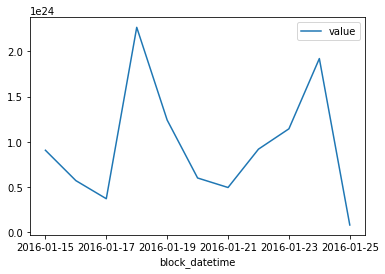

In [15]:
import glob
import pandas as pd

# Get CSV files list from a folder
csv_files = glob.glob("results/combined_results/outputs/*.csv")
df = pd.read_csv(csv_files[0], index_col='block_datetime')
df.plot()

### Massive Scale Ethereum Analysis

Ok so that works. Let's scale this up! We can run the same analysis on the entire Ethereum blockchain (up to the point where I have uploaded the Ethereum data). To do this, we need to run the analysis on each of the chunks of data that we have stored on IPFS. We can do this by running the same job on each of the chunks.

See the appendix for the `hashes.txt` file.

In [16]:
%%bash
printf "" > job_ids.txt
for h in $(cat hashes.txt); do \
    bacalhau docker run \
    --id-only \
    --wait=false \
    --input-volumes=$h:/inputs/data.tar.gz \
    ghcr.io/bacalhau-project/examples/blockchain-etl:0.0.6 >> job_ids.txt 
done

Now take a look at the job id's. You can use these to check the status of the jobs and download the results. You might want to double check that the jobs ran ok by doing a `bacalhau list`.

In [17]:
%%bash
cat job_ids.txt

445a479c-1e3e-4b32-a1e2-2c973f5a185b
0fbdd9a9-fa7c-43b9-8c8a-efdec0830eb7
f9c2c3d1-b9de-464b-b110-92d8d3ccfc4e
bd5cac66-37f6-40cc-9373-68b9d7c742e2
357a22cf-f41e-4a75-a9ab-5dce2bd7f825
7e60e598-01b9-4bf7-9f96-4a68ede4c7c3
98c35b9d-118c-4931-bdce-cb62c2921a27
a6f8a9cc-78ca-4386-8337-380e022e60d1
3c73312f-ca84-4e20-acd7-6af367543383
84ea57ea-eb17-4d8e-937b-a2cf4a9d16e7
098a6da7-b5bc-4e68-a3bb-6f9188c85ba6
c8c61b72-4b88-4f59-b9d1-1beb155e88ae
df5b95a5-f1b9-435a-9c14-15fe79ccf24d
ade9eb7d-77a7-471c-8a90-47e2b073fa0f
9ff874e9-3c94-457e-9c57-be4097a30ff6
00740e37-9eb6-4da4-8483-ab362e7db64b
0afd0a29-2460-4bf9-b9c0-ec0b2cbf9e44
b63de8f7-d98f-49a5-af57-b67524474960
61f57708-6405-462f-872c-4aa5107d70a7
014ecad4-65ca-4166-85cc-d343b6f77f30
02e7c151-e012-4be6-a9d2-abc47c3b4155
d7df3cc3-9f11-4c1f-80c9-edae9b3290a2
f9d34193-b175-4e42-9f9d-aed190a24587
038f4dd4-fdb7-4411-822c-88bc814ab4b2
464ef40c-0b87-4c8d-83e6-92e7ef2fd558
de74b3a6-8d97-416d-96bd-feabae46aa66
6d836a92-e421-459d-a9fe-e7db3300d2a7
d

Wait until all of these jobs have completed:

In [18]:
%%bash
bacalhau list -n 50

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 14:05:06  04b88a32  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:05  080985dc  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:05  0750b53e  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:04  8a1cadcc  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:03  a6308802  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:03  44d40215  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:02  a0684d59  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:01  bf9b1e4d  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:00  e4cda61b  Docker ghcr.io/bacal...  Cancelled                                    
 14:05:00  b6e545a2  Docker ghcr.io/bacal...  Cancelled                         

And then download all the results and merge them into a single directory. This might take a while, so this is a good time to treat yourself to a nice Dark Mild. There's also been some issues in the past communicating with IPFS, so if you get an error, try again.

In [22]:
%%bash
for id in $(cat job_ids.txt); do \
    rm -rf results_$id && mkdir results_$id
    bacalhau get --output-dir results_$id $id &
done
wait

Fetching results of job '0fbdd9a9-fa7c-43b9-8c8a-efdec0830eb7'...
Fetching results of job '84ea57ea-eb17-4d8e-937b-a2cf4a9d16e7'...
Fetching results of job 'a6308802-0792-47f1-a5af-9039d7e6fd70'...
Fetching results of job '445a479c-1e3e-4b32-a1e2-2c973f5a185b'...
Fetching results of job 'a6f8a9cc-78ca-4386-8337-380e022e60d1'...
Fetching results of job 'f9c2c3d1-b9de-464b-b110-92d8d3ccfc4e'...
Fetching results of job '7e60e598-01b9-4bf7-9f96-4a68ede4c7c3'...
Fetching results of job '3c73312f-ca84-4e20-acd7-6af367543383'...
Fetching results of job '098a6da7-b5bc-4e68-a3bb-6f9188c85ba6'...
Fetching results of job '357a22cf-f41e-4a75-a9ab-5dce2bd7f825'...
Fetching results of job '98c35b9d-118c-4931-bdce-cb62c2921a27'...
Fetching results of job 'de74b3a6-8d97-416d-96bd-feabae46aa66'...
Fetching results of job 'bd5cac66-37f6-40cc-9373-68b9d7c742e2'...
Fetching results of job '014ecad4-65ca-4166-85cc-d343b6f77f30'...
Fetching results of job '00740e37-9eb6-4da4-8483-ab362e7db64b'...
Fetching r

2022/11/28 14:32:52 CleanupManager.fnsMutex violation LOCK section took 241.608ms 241608000 (threshold 10ms)
2022/11/28 14:32:53 CleanupManager.fnsMutex violation CRITICAL section took 27.944ms 27944000 (threshold 10ms)
14:33:02.65 | ??? tcp/tcp.go:58 > ERROR tcp-tpt failed set keepalive period {"error": "set tcp4 127.0.0.1:4001->127.0.0.1:65444: setsockopt: invalid argument"}



<AxesSubplot:xlabel='block_datetime'>

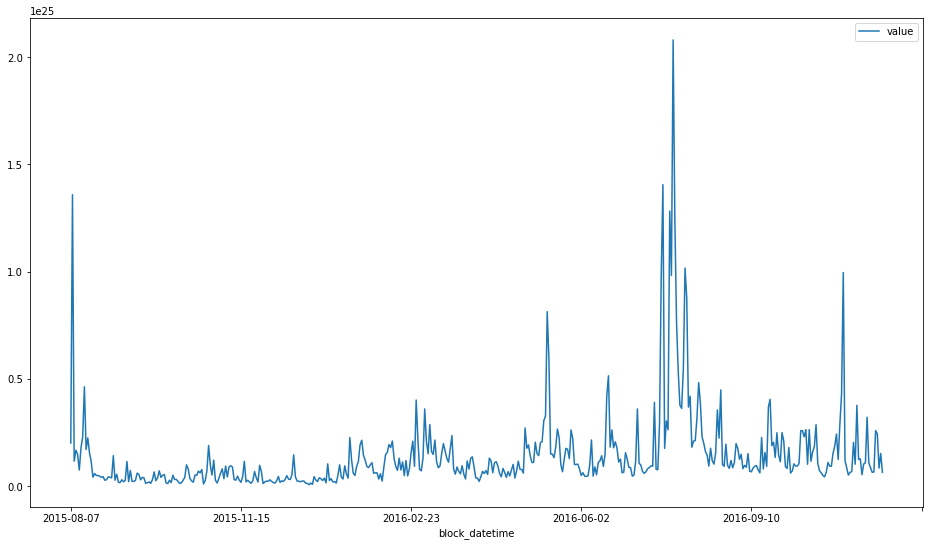

In [25]:
import os, glob
import pandas as pd

# Get CSV files list from a folder
path = os.path.join("results_*", "combined_results", "outputs", "*.csv")
csv_files = glob.glob(path)

# Read each CSV file into a list of DataFrames
df_list = (pd.read_csv(file, index_col='block_datetime') for file in csv_files)

# Concatenate all DataFrames
df_unsorted = pd.concat(df_list, ignore_index=False)

# Some files will cross days, so group by day and sum the values
df = df_unsorted.groupby(level=0).sum()

# Plot
df.plot(figsize=(16,9))

That's it! There is several years of Ethereum transaction volume data.

In [31]:
%%bash
rm -rf results_* output_* outputs results combined_results temp # Remove temporary results

## Appendix 1: List Ethereum Data CIDs 

The following list is a list of IPFS CID's for the Ethereum data that we used in this tutorial. You can use these CID's to download the rest of the chain if you so desire. The CIDs are ordered by block number and they increase 50,000 blocks at a time. Here's a list of ordered CIDs:

In [32]:
%%writefile hashes.txt
bafybeihvtzberlxrsz4lvzrzvpbanujmab3hr5okhxtbgv2zvonqos2l3i
bafybeifb25fgxrzu45lsc47gldttomycqcsao22xa2gtk2ijbsa5muzegq
bafybeig4wwwhs63ly6wbehwd7tydjjtnw425yvi2tlzt3aii3pfcj6hvoq
bafybeievpb5q372q3w5fsezflij3wlpx6thdliz5xowimunoqushn3cwka
bafybeih6te26iwf5kzzby2wqp67m7a5pmwilwzaciii3zipvhy64utikre
bafybeicjd4545xph6rcyoc74wvzxyaz2vftapap64iqsp5ky6nz3f5yndm
bafybeicgo3iofo3sw73wenc3nkdhi263yytjnds5cxjwvypwekbz4sk7ra
bafybeihvep5xsvxm44lngmmeysihsopcuvcr34an4idz45ixl5slsqzy3y
bafybeigmt2zwzrbzwb4q2kt2ihlv34ntjjwujftvabrftyccwzwdypama4
bafybeiciwui7sw3zqkvp4d55p4woq4xgjlstrp3mzxl66ab5ih5vmeozci
bafybeicpmotdsj2ambf666b2jkzp2gvg6tadr6acxqw2tmdlmsruuggbbu
bafybeigefo3esovbveavllgv5wiheu5w6cnfo72jxe6vmfweco5eq5sfty
bafybeigvajsumnfwuv7lp7yhr2sr5vrk3bmmuhhnaz53waa2jqv3kgkvsu
bafybeih2xg2n7ytlunvqxwqlqo5l3daykuykyvhgehoa2arot6dmorstmq
bafybeihnmq2ltuolnlthb757teihwvvw7wophoag2ihnva43afbeqdtgi4
bafybeibb34hzu6z2xgo6nhrplt3xntpnucthqlawe3pmzgxccppbxrpudy
bafybeigny33b4g6gf2hrqzzkfbroprqrimjl5gmb3mnsqu655pbbny6tou
bafybeifgqjvmzbtz427bne7af5tbndmvniabaex77us6l637gqtb2iwlwq
bafybeibryqj62l45pxjhdyvgdc44p3suhvt4xdqc5jpx474gpykxwgnw2e
bafybeidme3fkigdjaifkjfbwn76jk3fcqdogpzebtotce6ygphlujaecla
bafybeig7myc3eg3h2g5mk2co7ybte4qsuremflrjneer6xk3pghjwmcwbi
bafybeic3x2r5rrd3fdpdqeqax4bszcciwepvbpjl7xdv6mkwubyqizw5te
bafybeihxutvxg3bw7fbwohq4gvncrk3hngkisrtkp52cu7qu7tfcuvktnq
bafybeicumr67jkyarg5lspqi2w4zqopvgii5dgdbe5vtbbq53mbyftduxy
bafybeiecn2cdvefvdlczhz6i4afbkabf5pe5yqrcsgdvlw5smme2tw7em4
bafybeiaxh7dhg4krgkil5wqrv5kdsc3oewwy6ym4n3545ipmzqmxaxrqf4
bafybeiclcqfzinrmo3adr4lg7sf255faioxjfsolcdko3i4x7opx7xrqii
bafybeicjmeul7c2dxhmaudawum4ziwfgfkvbgthgtliggfut5tsc77dx7q
bafybeialziupik7csmhfxnhuss5vrw37kmte7rmboqovp4cpq5hj4insda
bafybeid7ecwdrw7pb3fnkokq5adybum6s5ok3yi2lw4m3edjpuy65zm4ji
bafybeibuxwnl5ogs4pwa32xriqhch24zbrw44rp22hrly4t6roh6rz7j4m
bafybeicxvy47jpvv3fi5umjatem5pxabfrbkzxiho7efu6mpidjpatte54
bafybeifynb4mpqrbsjbeqtxpbuf6y4frrtjrc4tm7cnmmui7gbjkckszrq
bafybeidcgnbhguyfaahkoqbyy2z525d3qfzdtbjuk4e75wkdbnkcafvjei
bafybeiefc67s6hpydnsqdgypbunroqwkij5j26sfmc7are7yxvg45uuh7i
bafybeiefwjy3o42ovkssnm7iihbog46k5grk3gobvvkzrqvof7p6xbgowi
bafybeihpydd3ivtza2ql5clatm5fy7ocych7t4czu46sbc6c2ykrbwk5uu
bafybeiet7222lqfmzogur3zlxqavlnd3lt3qryw5yi5rhuiqeqg4w7c3qu
bafybeihwomd4ygoydvj5kh24wfwk5kszmst5vz44zkl6yibjargttv7sly
bafybeidbjt2ckr4oooio3jsfk76r3bsaza5trjvt7u36slhha5ksoc5gv4
bafybeifyjrmopgtfmswq7b4pfscni46doy3g3z6vi5rrgpozc6duebpmuy
bafybeidsrowz46yt62zs64q2mhirlc3rsmctmi3tluorsts53vppdqjj7e
bafybeiggntql57bw24bw6hkp2yqd3qlyp5oxowo6q26wsshxopfdnzsxhq
bafybeidguz36u6wakx4e5ewuhslsfsjmk5eff5q7un2vpkrcu7cg5aaqf4
bafybeiaypwu2b45iunbqnfk2g7bku3nfqveuqp4vlmmwj7o7liyys42uai
bafybeicaahv7xvia7xojgiecljo2ddrvryzh2af7rb3qqbg5a257da5p2y
bafybeibgeiijr74rcliwal3e7tujybigzqr6jmtchqrcjdo75trm2ptb4e
bafybeiba3nrd43ylnedipuq2uoowd4blghpw2z7r4agondfinladcsxlku
bafybeif3semzitjbxg5lzwmnjmlsrvc7y5htekwqtnhmfi4wxywtj5lgoe
bafybeiedmsig5uj7rgarsjans2ad5kcb4w4g5iurbryqn62jy5qap4qq2a
bafybeidyz34bcd3k6nxl7jbjjgceg5eu3szbrbgusnyn7vfl7facpecsce
bafybeigmq5gch72q3qpk4nipssh7g7msk6jpzns2d6xmpusahkt2lu5m4y
bafybeicjzoypdmmdt6k54wzotr5xhpzwbgd3c4oqg6mj4qukgvxvdrvzye
bafybeien55egngdpfvrsxr2jmkewdyha72ju7qaaeiydz2f5rny7drgzta

Overwriting hashes.txt


## Appendix 2: Setting up an Ethereum Node

In the course of writing this example I had to setup an Ethereum node. It was a slow and painful process so I thought I would share the steps I took to make it easier for others.

### Geth setup and sync

Geth supports Ubuntu by default, so use that when creating a VM. Use Ubuntu 22.04 LTS.

```bash
gcloud compute instances create phil-ethereum-node \
    --project=bacalhau-development --zone=europe-west2-c \
    --machine-type=c2-standard-4 --tags=geth \
    --create-disk=auto-delete=yes,boot=yes,device-name=phil-ethereum-node,image=projects/ubuntu-os-cloud/global/images/ubuntu-2204-jammy-v20221101a,mode=rw,size=50,type=projects/bacalhau-development/zones/europe-west2-c/diskTypes/pd-balanced \
    --create-disk=auto-delete=yes,device-name=phil-ethereum-disk,mode=rw,name=phil-ethereum-disk,size=3000,type=projects/bacalhau-development/zones/europe-west2-c/diskTypes/pd-standard
```

Mount the disk:

```bash
sudo mkfs.ext4 -m 0 -E lazy_itable_init=0,lazy_journal_init=0,discard /dev/sdb
sudo mkdir -p /mnt/disks/ethereum
sudo mount -o discard,defaults /dev/sdb /mnt/disks/ethereum
sudo chmod a+w /mnt/disks/ethereum
```

```bash
sudo add-apt-repository -y ppa:ethereum/ethereum
sudo apt-get update
sudo apt-get install -y ethereum
sudo mkdir /prysm && cd /prysm
sudo curl https://raw.githubusercontent.com/prysmaticlabs/prysm/master/prysm.sh --output prysm.sh && sudo chmod +x prysm.sh
```

Run as a new user:

```bash
sudo useradd -d /home/ethuser -m --uid 10000 ethuser
sudo chown -R ethuser /prysm
```

```
sudo tee "/etc/systemd/system/geth.service" > /dev/null <<'EOF'
[Unit]
Description=Geth

[Service]
Type=simple
User=ethuser
Restart=always
RestartSec=12
ExecStart=/bin/geth --syncmode "full" --datadir /mnt/disks/ethereum

[Install]
WantedBy=default.target
EOF

sudo tee "/etc/systemd/system/prysm.service" > /dev/null <<'EOF'
[Unit]
Description=Prysm

[Service]
Type=simple
User=ethuser
Restart=always
RestartSec=12
ExecStart=/prysm/prysm.sh beacon-chain --execution-endpoint=/mnt/disks/ethereum/geth.ipc --suggested-fee-recipient=0x7f68cb1cdE000AF82291A0D0c21E0f88FD7dB440 --checkpoint-sync-url=https://beaconstate.info
--genesis-beacon-api-url=https://beaconstate.info --accept-terms-of-use --datadir /mnt/disks/ethereum/prysm

[Install]
WantedBy=default.target
EOF

sudo systemctl daemon-reload
sudo systemctl enable prysm.service
sudo systemctl enable geth.service
sudo systemctl daemon-reload
sudo service prysm start 
sudo service geth start 
```

Check they are running:

```bash
service prysm status
service geth status
```

Watch the logs:

```bash
journalctl -u prysm -f
```

Prysm will need to finish synchronising before geth will start syncronising.

In Prysm you will see lots of log messages saying: `Synced new block`, and in Geth you will see: `Syncing beacon headers    downloaded=11,920,384 left=4,054,753  eta=2m25.903s`. This tells you how long it will take to sync the beacons. Once that's done, get will start synchronising the blocks.

Bring up the ethereum javascript console with:

```
sudo geth --datadir /mnt/disks/ethereum/ attach
```

Once the block sync has started, `eth.syncing` will return values. Before it starts, this value will be `false`.

Note that by default, geth will perform a fast sync, without downloading the full blocks. The `syncmode=flull` flag forces geth to do a full sync. If we didn't do this, then we wouldn't be able to backup the data properly.

### Extracting the Data

```bash
# Install pip and ethereum-etl
sudo apt-get install -y python3-pip
sudo pip3 install ethereum-etl
cd
mkdir ethereum-etl
cd ethereum-etl

# Export data with one 50000-item batch in a directory. Up to this point we've processed about 3m.
# The full chain is about 16m blocks
for i in $(seq 0 50000 16000000); do sudo ethereumetl export_all --partition-batch-size 50000 --start $i --end $(expr $i + 50000 - 1)  --provider-uri file:///mnt/disks/ethereum/geth.ipc -o output_$i; done
```

### Upload the data

Tar and compress the directories to make them easier to upload:

```bash
sudo apt-get install -y jq # Install jq to parse the cid
cd
cd ethereum-etl
for i in $(seq 0 50000 16000000); do tar cfz output_$i.tar.gz output_$i; done
```

Export your Web3.storage JWT API key as an environment variable called `TOKEN`:

```bash
printf "" > hashes.txt
for i in $(seq 0 50000 16000000); do curl -X POST https://api.web3.storage/upload -H "Authorization: Bearer ${TOKEN}" -H 'accept: application/json' -H 'Content-Type: text/plain' -H "X-NAME: ethereum-etl-block-$i" --data-binary "@output_$i.tar.gz" >> raw.json; done
```
